# Tarea 2
## Profesor: Dr. Esteban Vargas; Alumno: Enrique Reyes
### 10/12/2020

El conjunto de datos a análizar contiene información sobre los reportes de contagios y muertes acumulados por SARS-CoV-2 Covid-19, dichas cifras van del 20 de enero de 2020 a 01 de marzo de 2020.

## 1. Carga de paquetes y datos

In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [2]:
import PDEparams as pde

In [3]:
# Cargamos los datos
cov = pd.read_csv("CoV2019.csv")
# Visualizamos los primeros elementos de la base de datos
cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date of report  41 non-null     object
 1   Days            41 non-null     int64 
 2   Total           41 non-null     int64 
 3   China           41 non-null     int64 
 4   Death China     41 non-null     int64 
 5   Other           41 non-null     int64 
 6   Death Outside   41 non-null     int64 
 7   Death Globally  41 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 2.7+ KB


In [4]:
cov.head()

,Date of report,Days,Total,China,Death China,Other,Death Outside,Death Globally
0,01/20/20,21,282,278,6,4,0,6
1,01/21/20,22,346,341,6,4,0,6
2,01/23/20,24,581,571,17,7,0,17
3,01/24/20,25,846,830,25,11,0,25
4,01/25/20,26,1320,1297,41,23,0,41


In [5]:
cov.tail()

,Date of report,Days,Total,China,Death China,Other,Death Outside,Death Globally
36,02/26/20,58,81109,78191,2718,2918,44,2762
37,02/27/20,59,82294,78630,2747,3664,57,2804
38,02/28/20,60,83652,78961,2791,4691,67,2858
39,02/29/20,61,85403,79394,2838,6009,86,2924
40,03/01/2020,62,87137,79579,2873,7169,104,2977


In [6]:
# Cargamos los datos
covi = pd.read_csv("data-1.csv")
# Visualizamos los primeros elementos de la base de datos
#covi.info()
MX= covi.loc[(covi.id == "MEX") & (covi.confirmed >= 1) , ['id', 'date', 'confirmed', 'recovered', 'deaths', 'population']]
MX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 39733 to 40019
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          287 non-null    object
 1   date        287 non-null    object
 2   confirmed   287 non-null    int64 
 3   recovered   287 non-null    int64 
 4   deaths      287 non-null    int64 
 5   population  287 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 15.7+ KB


In [7]:
MX.head()

,id,date,confirmed,recovered,deaths,population
39733,MEX,2020-02-28,1,0,0,126190788
39734,MEX,2020-02-29,4,0,0,126190788
39735,MEX,2020-03-01,5,0,0,126190788
39736,MEX,2020-03-02,5,0,0,126190788
39737,MEX,2020-03-03,5,1,0,126190788


In [8]:
MX.tail()

,id,date,confirmed,recovered,deaths,population
40015,MEX,2020-12-06,1175850,866186,109717,126190788
40016,MEX,2020-12-07,1182249,873555,110074,126190788
40017,MEX,2020-12-08,1193255,881050,110874,126190788
40018,MEX,2020-12-09,1205229,889168,111655,126190788
40019,MEX,2020-12-10,1205229,889168,111655,126190788


In [9]:
dt=np.arange(0,MX.count()[0])

In [10]:
MX.index = dt
MEX = pd.DataFrame(MX)
MEX.head()
SA = MEX.population - MEX.confirmed - MEX.recovered - MEX.deaths
IA = MEX.confirmed
RA = MEX.recovered + MEX.deaths
MEX1 = pd.concat([pd.DataFrame(dt),pd.DataFrame(SA),pd.DataFrame(IA),pd.DataFrame(RA)],axis=1)
MEX1.columns = ['t','S','I','R']
MEX1.head()

,t,S,I,R
0,0,126190787,1,0
1,1,126190784,4,0
2,2,126190783,5,0
3,3,126190783,5,0
4,4,126190782,5,1


## 2. Análsis Exploratorio de Datos

In [11]:
Otro = cov["Other"]
China_T = cov["China"]
Dias_T = cov["Days"]
Muertes_T_C = cov["Death China"]
Muertes_T_F = cov["Death Outside"]

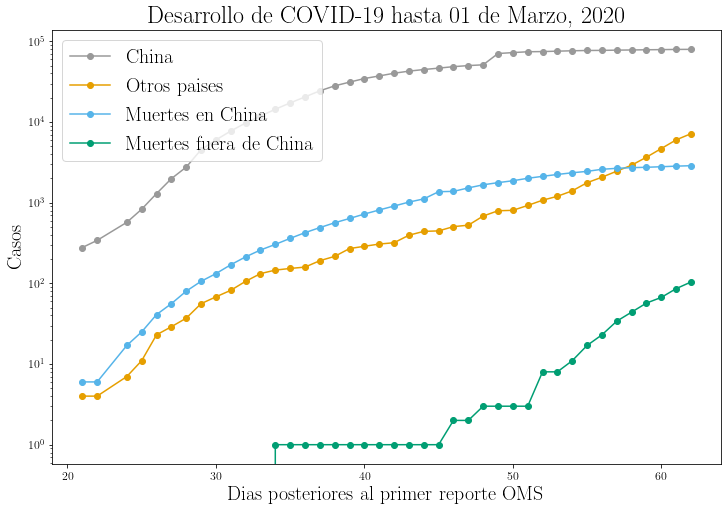

In [12]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo de COVID-19 hasta 01 de Marzo, 2020")
plt.plot(Dias_T, China_T, '-o', label="China")
plt.plot(Dias_T, Otro, '-o', label="Otros paises")
plt.plot(Dias_T, Muertes_T_C, '-o', label="Muertes en China")
plt.plot(Dias_T, Muertes_T_F, '-o', label="Muertes fuera de China")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Dias posteriores al primer reporte OMS")
plt.legend()

In [13]:
cov.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Days,41.0,41.951220,12.062237,21.0,32.0,42.0,52.0,62.0
Total,41.0,41301.024390,31543.398524,282.0,9826.0,40554.0,75748.0,87137.0
China,41.0,40253.512195,30371.936266,278.0,9720.0,40235.0,74675.0,79579.0
Death China,41.0,1181.365854,1025.027067,6.0,213.0,909.0,2121.0,2873.0
Other,41.0,1037.804878,1654.789235,4.0,106.0,319.0,1073.0,7169.0
Death Outside,41.0,11.878049,24.688251,0.0,0.0,1.0,8.0,104.0
Death Globally,41.0,1193.243902,1042.726757,6.0,213.0,910.0,2129.0,2977.0


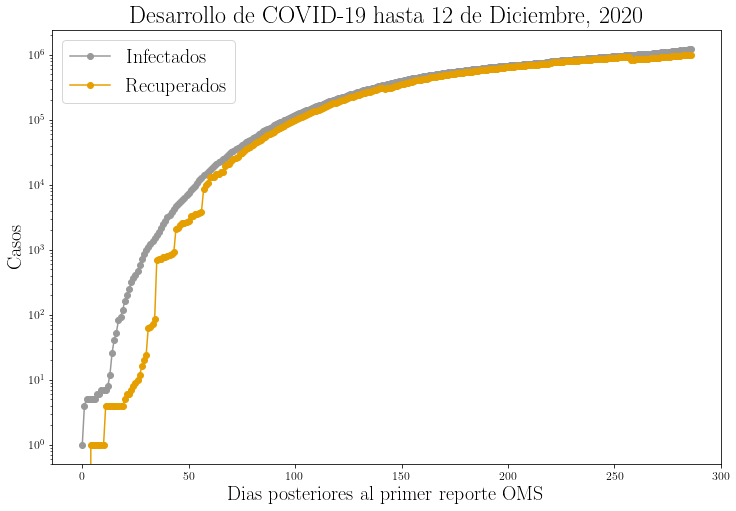

In [14]:
plt.figure(figsize=(12, 8))
plt.title("Desarrollo de COVID-19 hasta 12 de Diciembre, 2020")
plt.plot(dt, IA, '-o', label="Infectados")
plt.plot(dt, RA, '-o', label="Recuperados")
plt.yscale('log')
plt.ylabel("Casos")
plt.xlabel("Dias posteriores al primer reporte OMS")
plt.legend()

In [15]:
MEX1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t,287.0,1.430000e+02,82.993976,0.0,71.5,143.0,214.5,286.0
S,287.0,1.253877e+08,726602.113648,123984736.0,124745934.5,125538816.0,126131314.0,126190787.0
I,287.0,4.219887e+05,382488.288471,1.0,34241.0,349396.0,740689.5,1205229.0
R,287.0,3.811378e+05,344771.121406,0.0,25233.0,307807.0,704164.0,1000823.0


## 3. Modelos de ecuaciones diferenciales
### 3.1 SIR

<style>
p.comment {
background-color: #DBDBDB;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

Es un modelo de ecuaciones diferenciales utilizado en epidemiología para modelar el compotamiento de enfermedades infecciosas, fue diseñado en 1927 por los médicos W. O. Kermack y A. G. McKendrick. Cuando una enfermedad es nueva como el **SARS-CoV 2 (Covid 19)** todos los habitantes de una población son candidatos a contraer dicha enfermedad con la misma probabilidad, con forme avanza el brote infeccioso diferentes condiciones hacen que aumente o disminuya la probabilidad de ser contagiado.
<p></p>
Un supuesto que se hace en este modelo es pensar en una población cerrada ante nacimientos y migración, por lo tanto la población inicial

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
    </ul>
</div>


$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I \\
\frac{dR}{dt}&=& \gamma I
\end{eqnarray}
$$


In [16]:
# Modelo
def SIR(z, t, beta1, gamma1):
    
    S, I, R= z
    
    return [-(beta1/N)*S*I, (beta1/N)*S*I-gamma1*I,gamma1*I]

In [17]:
N = 1392730000  # Población inicial
nid=5           # Periodo de incuvacion
nr=2.5          # Numero de reproduccion
tb=nr/nid       # tasa de transmision
tg=1/nid        # tasa de recuperacion

def initial_S():
    return N-1   # S_0

def initial_I():   
    return 1     # I_0

def initial_R():
    return 0       # R_0

# Construcción de la tabla (Tmp, Sus, Inf, Rec, Pob)
Pob = np.repeat(N, 41, axis=0)
Rec = Muertes_T_C
Sus = N-China_T-Muertes_T_C
cov1 = pd.concat([pd.DataFrame(Dias_T), pd.DataFrame(Sus), pd.DataFrame(China_T), pd.DataFrame(Rec)], axis=1)
cov1.columns = ['t','S','I','R']
cov1.head()

,t,S,I,R
0,21,1392729716,278,6
1,22,1392729653,341,6
2,24,1392729412,571,17
3,25,1392729145,830,25
4,26,1392728662,1297,41


In [18]:
my_model = pde.PDEmodel(cov1, SIR, [initial_S,initial_I,initial_R], bounds=[(0.01, 1), (0.01,1)], 
                        param_names=[r'$beta1$', r'$gamma1$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [19]:
# Printing the initial condition
my_model.initial_condition

array([1392729999,          1,          0])

In [20]:
%%time
my_model.fit()

    $beta1$  $gamma1$
0  0.201512  0.011403
Wall time: 2.94 s


In [21]:
my_model.best_params

,$beta1$,$gamma1$
0,0.201512,0.011403


In [22]:
my_model.best_error

722676618.0749975

In [23]:
%%time
my_model.likelihood_profiles()



Wall time: 3min 27s


In [24]:
my_model.result_profiles

,parameter,value,error
0,$beta1$,0.01,1.733263e+09
1,$beta1$,0.02,1.733222e+09
2,$beta1$,0.03,1.733154e+09
3,$beta1$,0.04,1.733040e+09
4,$beta1$,0.05,1.732848e+09
...,...,...,...
195,$gamma1$,0.96,1.728149e+09
196,$gamma1$,0.97,1.729675e+09
197,$gamma1$,0.98,1.730687e+09
198,$gamma1$,0.99,1.731370e+09


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


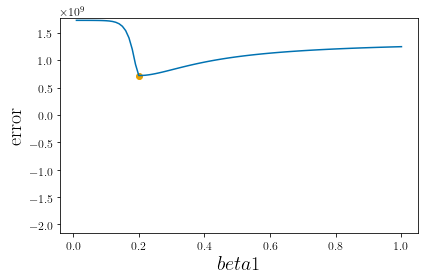

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


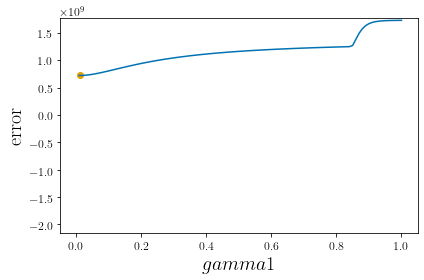

In [25]:
my_model.plot_profiles()

In [26]:
# Resto del mundo
N=56*10**3
def S0():
    return N-1   # S_0

def I0():   
    return 1     # I_0

def R0():
    return 0       # R_0

# Construcción de la tabla (Tmp, Sus, Inf, Rec, Pob)
Pob = np.repeat(N, 41, axis=0)
Rec = Muertes_T_F
Sus = N-Otro-Muertes_T_F
cov2 = pd.concat([pd.DataFrame(Dias_T), pd.DataFrame(Sus), pd.DataFrame(Otro), pd.DataFrame(Rec)], axis=1)
cov2.columns = ['t','S','I','R']
cov2.head()

,t,S,I,R
0,21,55996,4,0
1,22,55996,4,0
2,24,55993,7,0
3,25,55989,11,0
4,26,55977,23,0


In [27]:
modelo2 = pde.PDEmodel(cov2, SIR, [S0,I0,R0], bounds=[(0.01, 1), (0.01,1)], 
                        param_names=[r'$beta1$', r'$gamma1$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [28]:
# Printing the initial condition
modelo2.initial_condition

array([55999,     1,     0])

In [29]:
%%time
modelo2.fit()

    $beta1$  $gamma1$
0  0.151399      0.01
Wall time: 4.07 s


In [30]:
modelo2.best_params

,$beta1$,$gamma1$
0,0.151399,0.01


In [31]:
modelo2.best_error

98338.14083250075

In [32]:
%%time
modelo2.likelihood_profiles()



Wall time: 3min 2s


In [33]:
modelo2.result_profiles

,parameter,value,error
0,$beta1$,0.01,2.532287e+06
1,$beta1$,0.02,2.531098e+06
2,$beta1$,0.03,2.529028e+06
3,$beta1$,0.04,2.525404e+06
4,$beta1$,0.05,2.519022e+06
...,...,...,...
195,$gamma1$,0.96,2.390375e+06
196,$gamma1$,0.97,2.433214e+06
197,$gamma1$,0.98,2.462056e+06
198,$gamma1$,0.99,2.481486e+06


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


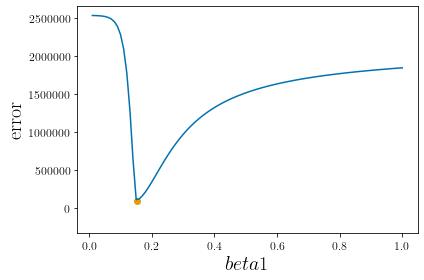

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


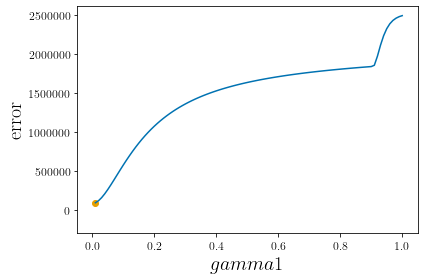

In [34]:
modelo2.plot_profiles()

In [35]:
# Poblacion
N=MEX.population[0]
# Iniciales
def SMX():
    return N-1   # S_0
def IMX():   
    return 1     # I_0
def RMX():
    return 0       # R_0
# Base
CoVMX=MEX1[0:41]
CoVMX.head()

,t,S,I,R
0,0,126190787,1,0
1,1,126190784,4,0
2,2,126190783,5,0
3,3,126190783,5,0
4,4,126190782,5,1


In [36]:
modeloMX = pde.PDEmodel(CoVMX, SIR, [SMX,IMX,RMX], bounds=[(0, 1), (0,1)], 
                        param_names=[r'$beta1$', r'$gamma1$'], nvars=3, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [37]:
# Printing the initial condition
modeloMX.initial_condition

array([126190787,         1,         0], dtype=int64)

In [38]:
%%time
modeloMX.fit()

    $beta1$  $gamma1$
0  0.263344  0.057951
Wall time: 858 ms


In [39]:
modeloMX.best_params

,$beta1$,$gamma1$
0,0.263344,0.057951


In [40]:
modeloMX.best_error

45237.22490964754

In [41]:
%%time
modeloMX.likelihood_profiles()



Wall time: 1min 14s


In [42]:
modeloMX.result_profiles

,parameter,value,error
0,$beta1$,0.000000,966610.504065
1,$beta1$,0.010101,966238.218551
2,$beta1$,0.020202,965706.446826
3,$beta1$,0.030303,964945.362788
4,$beta1$,0.040404,963854.116377
...,...,...,...
195,$gamma1$,0.959596,922651.735318
196,$gamma1$,0.969697,931327.690512
197,$gamma1$,0.979798,938005.881415
198,$gamma1$,0.989899,943175.101265


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


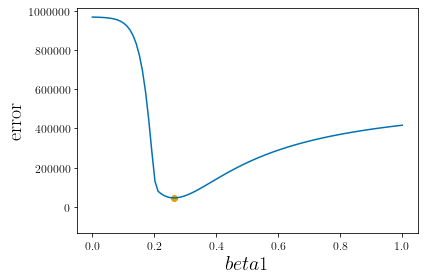

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


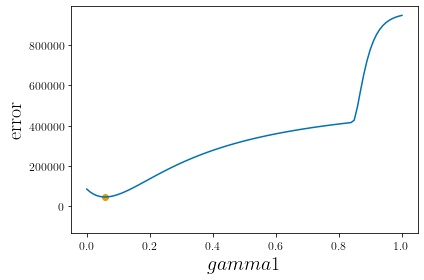

In [43]:
modeloMX.plot_profiles()

### 3.2 SIR-D

En el modelo anterior se considero a los Recuperados como aquellas personas que ya no se podían infectar, es decir personas que son inmunes temporalmente y a los muertos, pero ahora veremos que pasa si los consideramos por separado.

<style>
p.comment {
background-color: #FFFFFF;
padding: 10px;
border: 1px solid black;
margin-left: 25px;
border-radius: 5px;
font-style: italic;
}
</style>

<div class="alert alert-info">
    <ul>
      <li><strong>Susceptibles:</strong> personas que pueden contraer la enfermedad.</li>
      <li><strong>Infectados:</strong> personas que contrajeron la enfermedad y pueden contagiar a los demás.</li>
      <li><strong>Recuperados:</strong> personas que salieron de la enfermedad y adquieren inmunidad temporal.</li>
      <li><strong>Defunciones:</strong> personas que salieron de la enfermedad y murieron.</li>
    </ul>
</div>

$$
\begin{eqnarray}
\frac{dS}{dt}&=& -\beta S\frac{I}{N} \\
\frac{dI}{dt}&=& \beta S\frac{I}{N} - \gamma I - \epsilon D \\
\frac{dR}{dt}&=& \gamma I \\
\frac{dD}{dt}&=& \epsilon D 
\end{eqnarray}
$$


In [44]:
def SIRD(z, t, beta2, gamma2, epsilon1):
    
    S, I, R, D = z
    
    return [-beta2*S*I/N, beta2*S*I/N-gamma2*I-epsilon1*D, gamma2*I, epsilon1*D]

In [45]:
N=MEX.population[0]
# Iniciales
def SMX1():
    return N-1   # S_0
def IMX1():   
    return 1     # I_0
def RMX1():
    return 0       # R_0
def DMX1():
    return 0       # D_0
# Base

SA1 = MEX.population - MEX.confirmed - MEX.recovered - MEX.deaths
IA1 = MEX.confirmed
RA1 = MEX.recovered 
DA1 = MEX.deaths
MEX2 = pd.concat([pd.DataFrame(dt),pd.DataFrame(SA1),pd.DataFrame(IA1),pd.DataFrame(RA1), pd.DataFrame(DA1)],axis=1)
MEX2.columns = ['t','S','I','R','D']

CoVMX1=MEX2[0:41]
CoVMX1.head()

,t,S,I,R,D
0,0,126190787,1,0,0
1,1,126190784,4,0,0
2,2,126190783,5,0,0
3,3,126190783,5,0,0
4,4,126190782,5,1,0


In [53]:
modeloMX1 = pde.PDEmodel(CoVMX1, SIRD, [SMX1,IMX1,RMX1,DMX1], bounds=[(0, 1), (0,1),(0,1)], 
                        param_names=[r'$beta2$', r'$gamma2$', r'$epsilon1$'], nvars=4, ndims=0, nreplicates=1, obsidx=None, outfunc=None)

In [54]:
# Printing the initial condition
modeloMX1.initial_condition

array([126190787,         1,         0,         0], dtype=int64)

In [55]:
%%time
modeloMX1.fit()

    $beta2$  $gamma2$  $epsilon1$
0  0.256536  0.050731    0.771825
Wall time: 985 ms


In [56]:
modeloMX1.best_params

,$beta2$,$gamma2$,$epsilon1$
0,0.256536,0.050731,0.771825


In [57]:
modeloMX.best_error

45237.22490964754

In [60]:
%%time
modeloMX1.likelihood_profiles()



Wall time: 4min 29s


In [61]:
modeloMX1.result_profiles

,parameter,value,error
0,$beta2$,0.000000,719697.329268
1,$beta2$,0.010101,719418.115133
2,$beta2$,0.020202,719019.286351
3,$beta2$,0.030303,718448.473309
4,$beta2$,0.040404,717630.038508
...,...,...,...
295,$epsilon1$,0.959596,34898.972332
296,$epsilon1$,0.969697,34896.183171
297,$epsilon1$,0.979798,34896.179945
298,$epsilon1$,0.989899,34896.176073


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


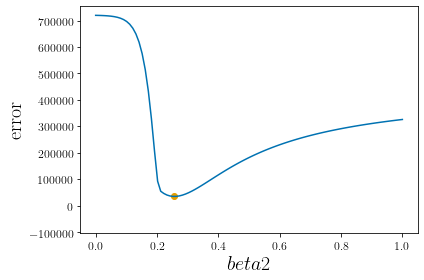

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


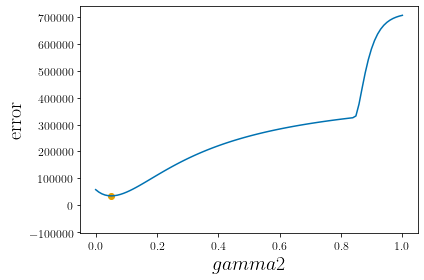

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


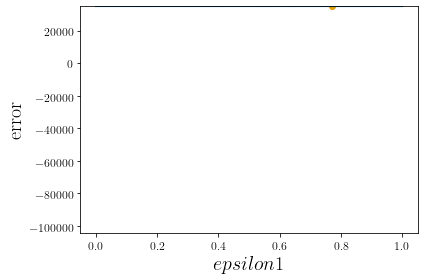

In [62]:
modeloMX1.plot_profiles()

## 4. Conclusiones

Notamos que en los 4 casos tenemos tasas de contagio mucho mayores a las tasas de recuperación:

|Población | $\beta$ | $\gamma$ | $\frac{\beta}{\gamma}$ |
|------|-------|----|----|
| China  | 0.201512 |  0.011403    | 17.67184   |
| Otros  | 0.151399 |   0.01    |  15.1399  |
| Mexico | 0.263344 |  0.057951    | 4.54425   |


Aquí notamos que la probabilidad de contagiarse debido a la tasa de contacto en México al inicio de la pandemia era mayor que en China, así mismo notamos que la tasa de recuperación, en términos globales es mayor, sólo que en este punto hay que aclarar que para el caso de China desconocemos a los recuperados que quedaron vivos.